In [57]:
from wrf import getvar, ALL_TIMES
from glob import glob
from netCDF4 import Dataset as nc

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import get_cmap
import matplotlib.transforms as mtransforms
from matplotlib.offsetbox import AnchoredText

import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, vinterp, ll_to_xy, interplevel)

from metpy.plots import USCOUNTIES

from palettable.colorbrewer.diverging import RdBu_11_r


In [3]:
### define a scalebar, from https://stackoverflow.com/a/41600150/13836965

from math import floor
from matplotlib import patheffects

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = crs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    #t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
    #    horizontalalignment='center', verticalalignment='bottom',
    #    path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)


working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:30:00


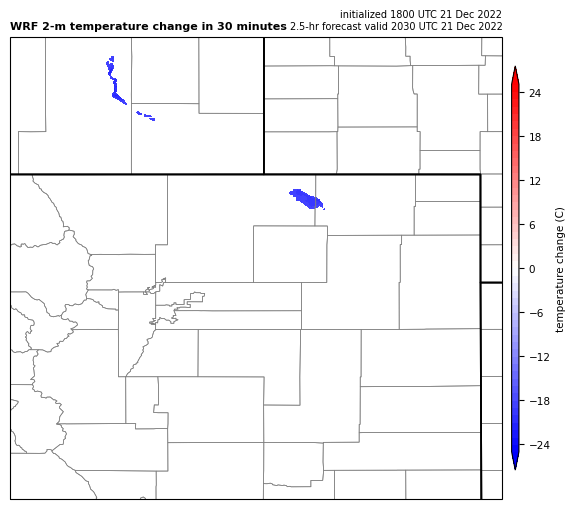

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:40:00


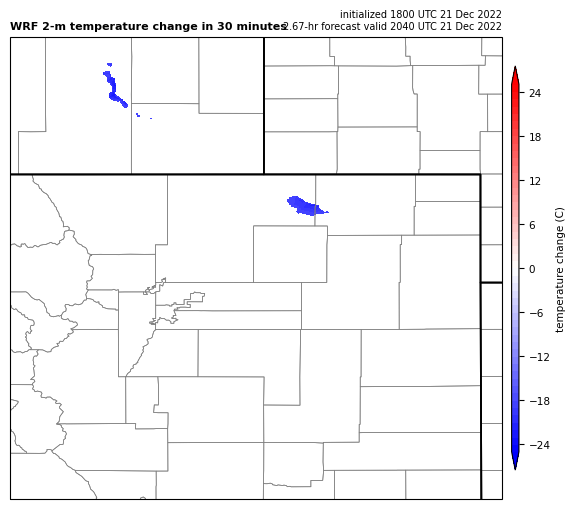

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:50:00


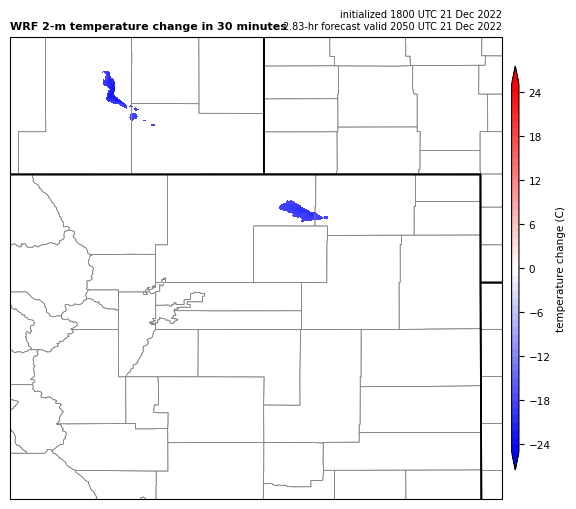

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:00:00


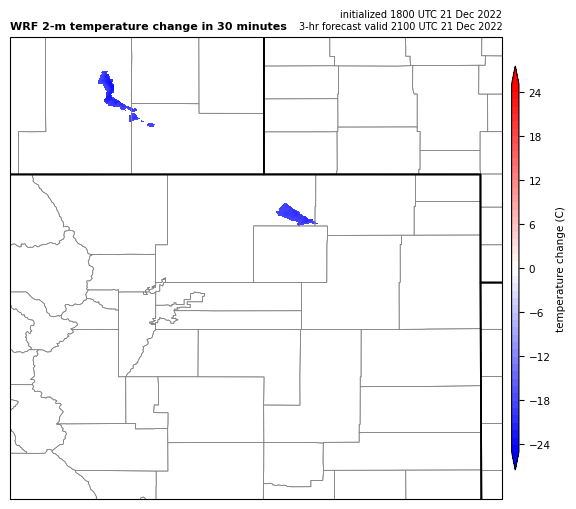

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:10:00


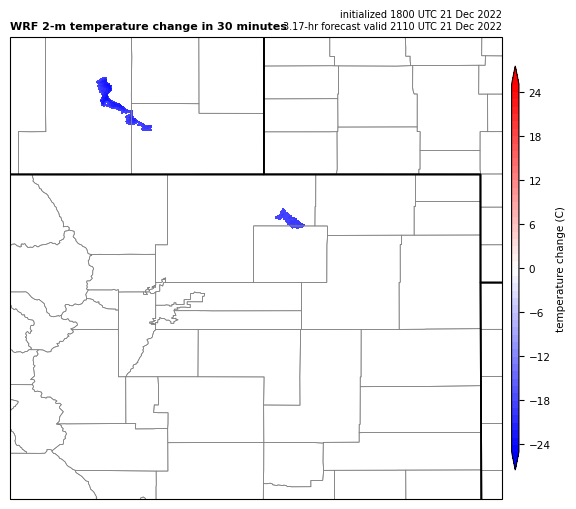

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:20:00


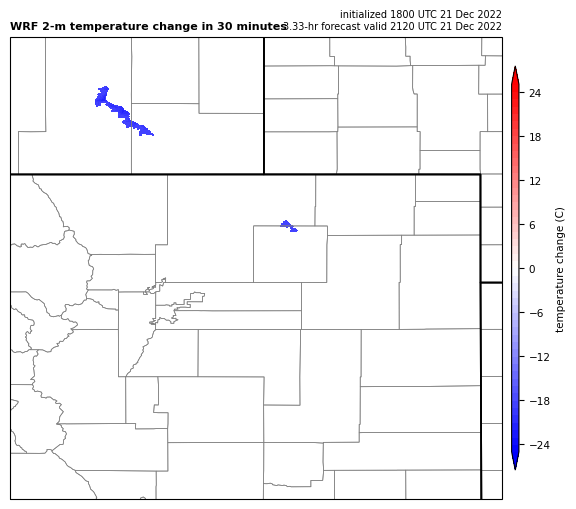

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:30:00


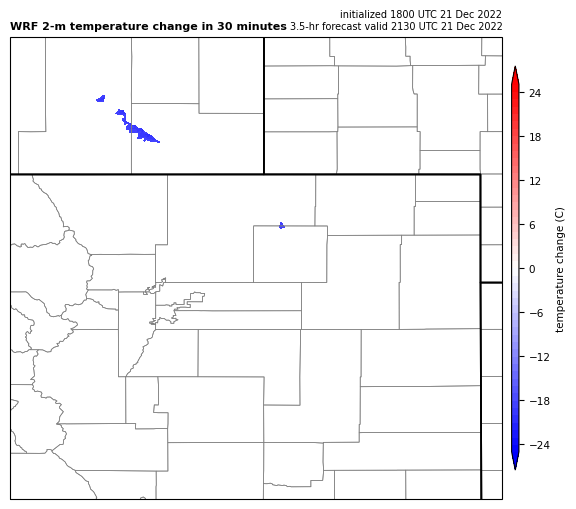

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:40:00


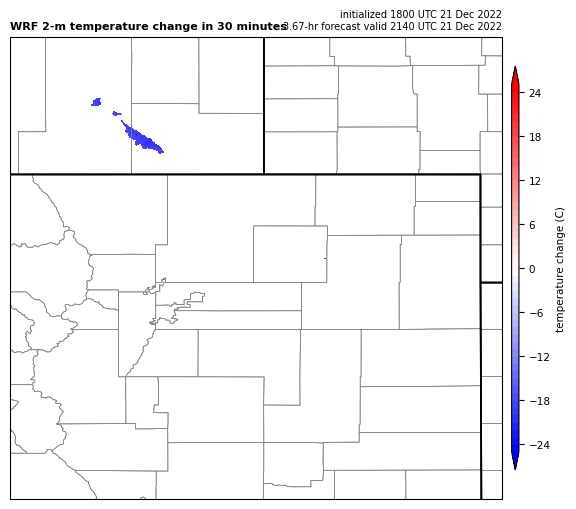

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_21:50:00


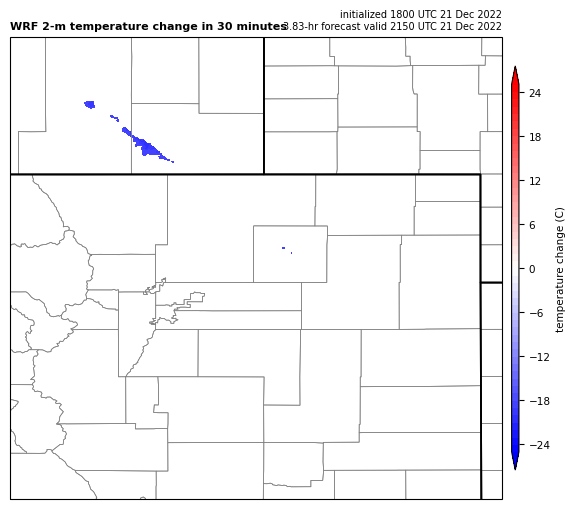

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:00:00


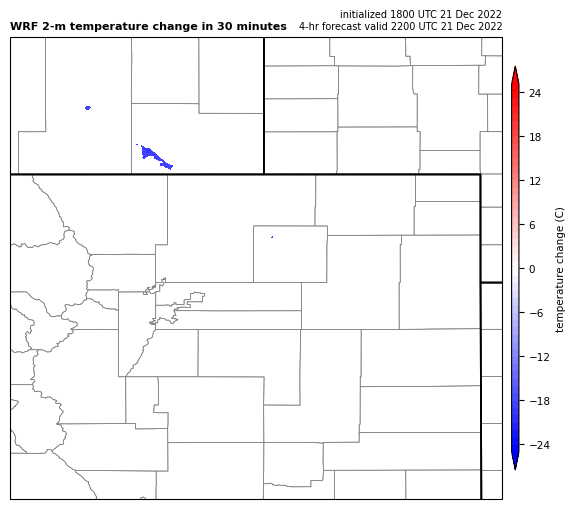

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:10:00


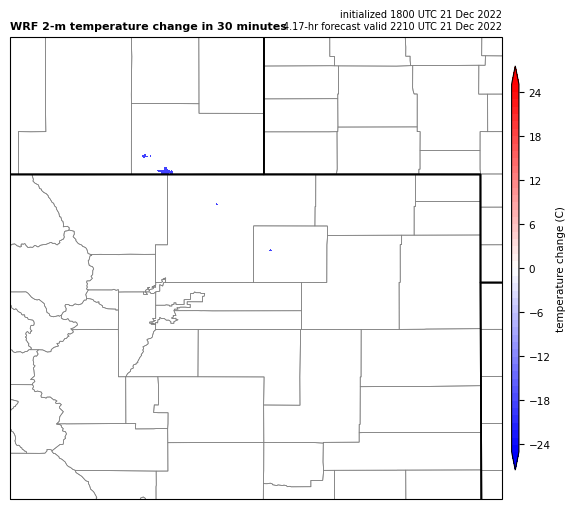

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:20:00


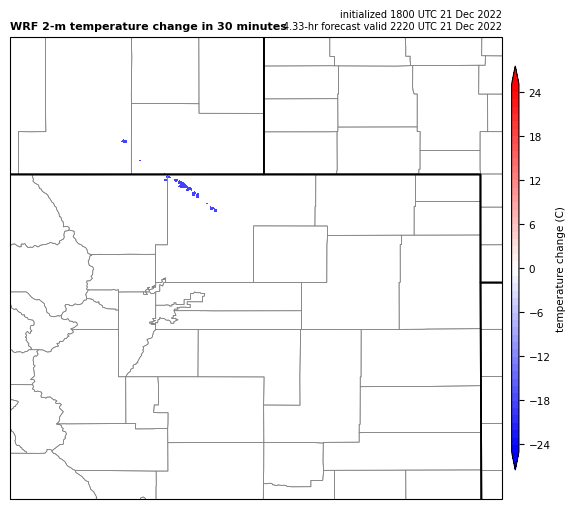

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:30:00


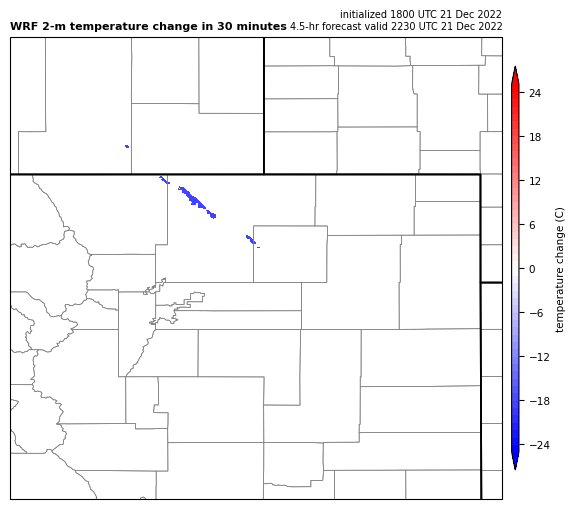

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:40:00


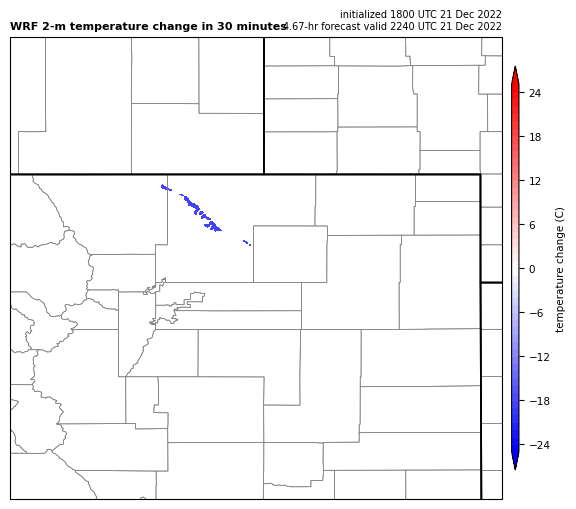

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_22:50:00


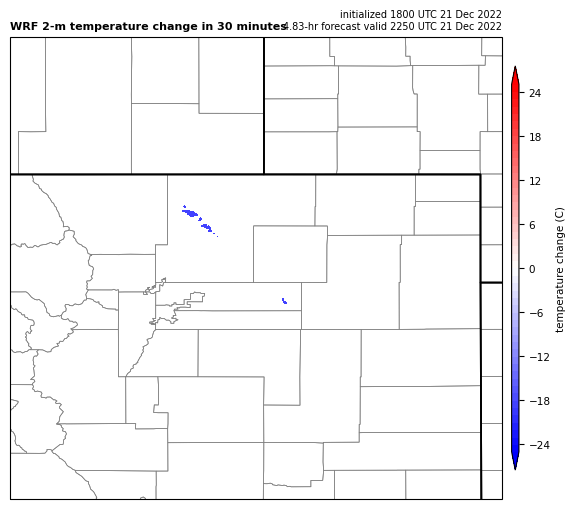

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:00:00


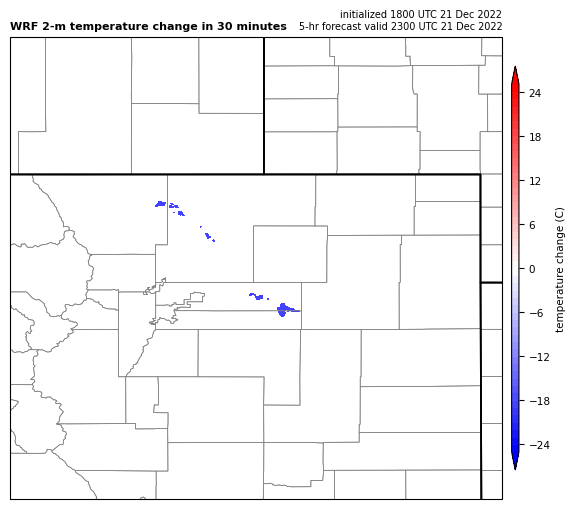

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:10:00


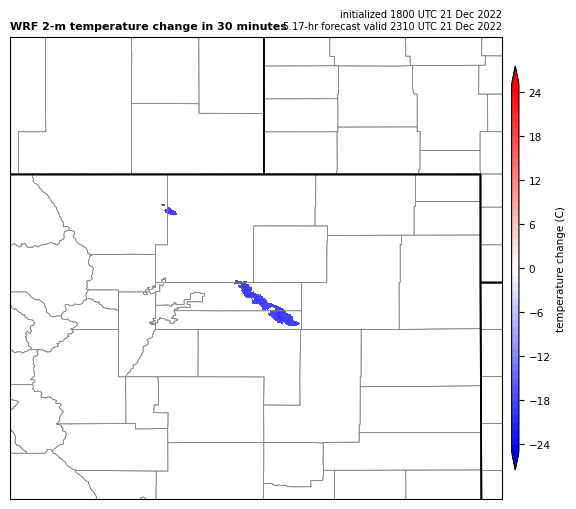

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:20:00


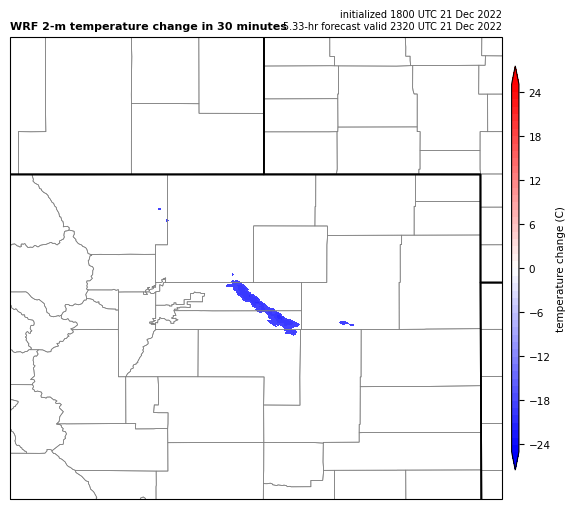

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:30:00


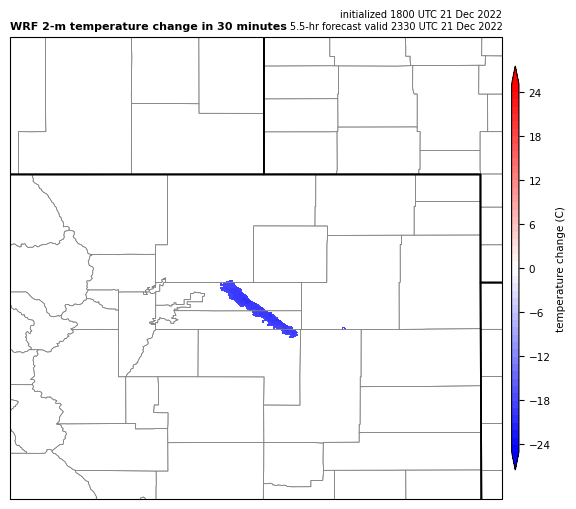

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:40:00


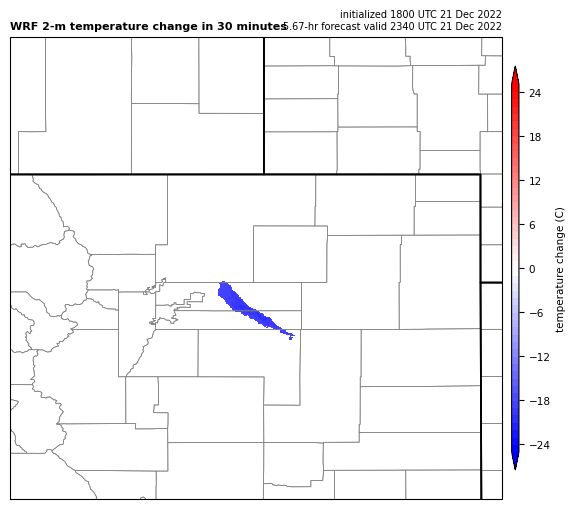

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:50:00


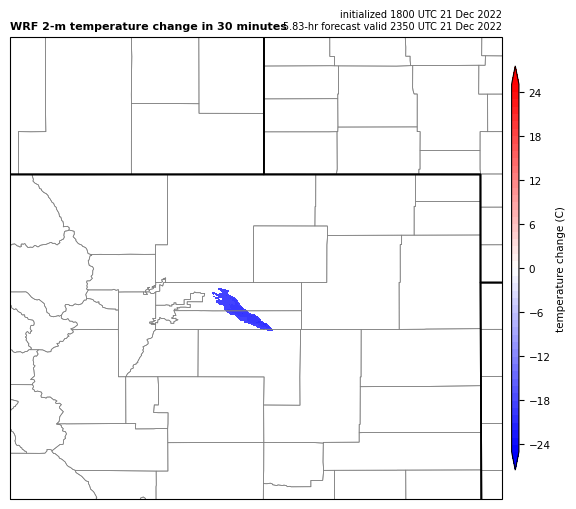

In [3]:
## now we're going to make plots for a series of hours
## define our end hours

init = pd.Timestamp(2022,12,21,18)

#endhrs=['23:50']
endhrs=['20:30','20:40','20:50','21:00','21:10','21:20','21:30','21:40','21:50','22:00',
    '22:10','22:20','22:30','22:40','22:50','23:00',
      '23:10','23:20','23:30','23:40','23:50']

diff_minutes = 30  ##### how many minutes to calculate the difference? 

for endhr in endhrs:
    
    ## get the times we need
    times = pd.date_range(start=pd.Timestamp('2022-12-21 '+str(endhr)) - pd.Timedelta(minutes=diff_minutes), end='2022-12-21 '+str(endhr), 
                          freq=str(diff_minutes)+"min")


    # wrf filenames matching these times
    wrf_filenames = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+times.strftime("%Y-%m-%d_%H:%M:%S") 
    
    ## identify the two files here
    wrf_filename_last = wrf_filenames[-1]
    wrf_filename_first = wrf_filenames[0]
    
    print("working on "+wrf_filename_last)
    
    ## read in some files
    ncfile_last = [nc(wrf_filename_last)]
    ncfile_first = [nc(wrf_filename_first)]
    
    ## read in T2 
    t2m_end = getvar(ncfile_last,"T2")
    t2m_start = getvar(ncfile_first,"T2")
    
    ## valid time
    vtime = pd.to_datetime(t2m_end.Time.values)
    
    ## what's the lead time (in hours)?
    fcst_lead = np.round((t2m_end.XTIME/60.).values,2)
    ## format this more nicely (removing the decimal if it's the top of the hour)
    fcst_lead_nice = int(fcst_lead.item()) if fcst_lead.item().is_integer() else np.round(fcst_lead.item(),2)
    
    ####### now let's make a map of reflectivity and the surface wind swath
    # Get the latitude and longitude points
    lats, lons = latlon_coords(t2m_end)

    # Get the cartopy mapping object
    #cart_proj = get_cartopy(dbz_1km)
    cart_proj = ccrs.PlateCarree()
    
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)
    
    # Add some various map elements to the plot to make it recognizable.
   # ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'),linewidth=1.25)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    
    #ax.set_extent([-106.49114990234375,-101.61444091796875,37.97676467895508,42.27891540527344])
    ax.set_extent([-106.4,-101.85,38.0,42.27])    
    
    cf = ax.contourf(to_np(lons), to_np(lats), to_np((t2m_end - t2m_start).where((t2m_end-t2m_start) < -18)), 
                    np.arange(-25,26,1),
                       cmap='bwr',
                     extend='both',
                      transform_first=True,
                 transform=ccrs.PlateCarree())
      
    cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                      shrink=0.875, aspect=50)
    cb.ax.tick_params(labelsize=7.5)
    cb.set_label('temperature change (C)', fontsize=7.5)
    #cb.locator = ticker.MaxNLocator(nbins=14)
    #cb.update_ticks()

    # add titles
    plt.title("WRF 2-m temperature change in "+str(diff_minutes)+" minutes",
              loc='left', weight='bold', fontsize=8)
    plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(fcst_lead_nice)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
          loc='right', fontsize=7)
    
    plt.show()

    fig.savefig("t2m_change_"+str(diff_minutes)+"_"+init.strftime("%Y%m%d%H")+"_"+vtime.strftime("%H%M")+".png",
               bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

    plt.close('all')

### now get CoAgMET data to plot the same thing on here

In [10]:
coag = pd.read_csv("https://coagmet.colostate.edu/data/5min.csv?header=yes&from=2022-12-21&to=2022-12-23&fields=t,rh,dewpt,solarRad,precip,windSpeed,windDir,gustSpeed,gustDir&units=m&tz=utc",
                  skiprows=[1], parse_dates=['Date and Time'])

meta = pd.read_csv("https://coagmet.colostate.edu/data/metadata.csv?header=yes")
coag = coag.merge(meta)

coag.replace(-999.,np.nan,inplace=True)
coag['Date and Time'] = coag['Date and Time'].dt.tz_localize("UTC")
coag.set_index(['Date and Time'],inplace=True)

### get stations with only hourly data
hourly = pd.read_csv("https://coagmet.colostate.edu/data/hourly.csv?header=yes&from=2022-12-21&to=2022-12-23&fields=t,rh,dewpt,solarRad,precip,windSpeed,windDir,gustSpeed,gustDir&units=m&tz=utc",
                  skiprows=[1], parse_dates=['Date and Time'])
## remove the stations that have 5-min data
fivemin_stns = coag.Station.unique()
hourly = hourly[~hourly.Station.isin(fivemin_stns)]
hourly = hourly.merge(meta)

hourly.replace(-999.,np.nan,inplace=True)
hourly['Date and Time'] = hourly['Date and Time'].dt.tz_localize("UTC")
hourly.set_index(['Date and Time'],inplace=True)

### get NW data too
nw = pd.read_csv("https://coagmet.colostate.edu/data/nw/15min.csv?header=yes&from=2022-12-21&to=2022-12-22&units=m&tz=utc",
                  skiprows=[1], parse_dates=['Date and Time'])

meta_nw = pd.read_csv("https://coagmet.colostate.edu/data/nw/metadata.csv?header=yes")
nw = nw.merge(meta_nw)

nw.replace(-999.,np.nan,inplace=True)
nw['Date and Time'] = nw['Date and Time'].dt.tz_localize("UTC")
nw.set_index(['Date and Time'],inplace=True)

nw.rename(columns={'Avg Temp':'Air Temp'},inplace=True) ### rename avg temp to air temp

### merge them
#coag = pd.concat([coag,hourly,nw])
coag = pd.concat([coag,nw])
coag = coag.sort_index()

### do a time subset
coag_east = coag[:'2022-12-22 12:00']

### remove western CO stations
coag_east = coag_east[coag_east['Longitude (degE)'] > -105.6]

coag_east

,Station,Air Temp,RH,Dewpoint,Solar Rad,Precip,Wind,Wind Dir,Gust Speed,Gust Dir,...,Longitude (degE),Elevation (ft),Anemometer Height (m),Active,Irrigation,First Observation,Last Observation,Timestep (s),Network,10cm Soil Temp
Date and Time,,,,,,,,,,,,,,,,,,,,,
2022-12-21 00:00:00+00:00,avn01,-2.46,0.671,-7.73,0.05,0.00,2.46,102.6,3.35,113.3,...,-104.3294,4630,2,active,full,06/04/1992,11/12/2024,300,Coag,NaN
2022-12-21 00:00:00+00:00,wls01,1.63,0.488,-8.00,0.02,0.00,3.63,134.6,4.32,138.6,...,-102.2940,3974,2,active,dry,04/11/2012,11/12/2024,300,Coag,NaN
2022-12-21 00:00:00+00:00,wcf01,2.65,0.292,-13.55,0.00,0.00,3.15,243.2,4.25,259.2,...,-105.4988,7734,2,active,full,09/20/2010,11/12/2024,300,Coag,NaN
2022-12-21 00:00:00+00:00,ccr01,4.23,0.293,-12.13,0.08,0.00,1.50,167.1,2.38,185.9,...,-104.8339,5632,2,active,dry,07/25/2019,11/12/2024,300,Coag,NaN
2022-12-21 00:00:00+00:00,stn01,-3.84,0.560,-11.34,0.00,0.00,4.63,139.2,5.82,135.0,...,-102.5220,4321,3,active,dry,04/02/2006,11/12/2024,300,Coag,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 12:00:00+00:00,ckp01,-27.04,0.744,-30.21,0.00,0.00,0.00,0.0,0.00,242.3,...,-105.2670,5956,2,active,dry,07/25/2014,11/12/2024,300,Coag,NaN
2022-12-22 12:00:00+00:00,lam04,-21.37,0.799,-23.91,0.00,0.00,7.77,346.7,10.10,354.6,...,-102.5986,3703,2,active,full,05/11/2005,11/12/2024,300,Coag,NaN
2022-12-22 12:00:00+00:00,lmt02,-23.93,0.796,-26.46,0.00,NaN,1.29,125.7,2.94,NaN,...,-105.1230,5053,6,active,full,07/31/1997,11/12/2024,900,NW,0.94


### do some calculations of temperature changes

In [11]:
coag_east.set_index([coag_east.index,"Station"],inplace=True)
### for some reason there end up being some duplicated rows; remove them:
coag_east = coag_east[~coag_east.index.duplicated()]

In [12]:
coag_east

Air Temp     RH  Dewpoint  Solar Rad  \
Date and Time             Station                                         
2022-12-21 00:00:00+00:00 avn01       -2.46  0.671     -7.73       0.05   
                          wls01        1.63  0.488     -8.00       0.02   
                          wcf01        2.65  0.292    -13.55       0.00   
                          ccr01        4.23  0.293    -12.13       0.08   
                          stn01       -3.84  0.560    -11.34       0.00   
...                                     ...    ...       ...        ...   
2022-12-22 12:00:00+00:00 ckp01      -27.04  0.744    -30.21       0.00   
                          lam04      -21.37  0.799    -23.91       0.00   
                          lmt02      -23.93  0.796    -26.46       0.00   
                          ovd01      -27.46  0.706    -31.17       0.00   
                          ftm02      -24.69  0.642    -29.51       0.00   

                                   Precip  Wind  Wind Dir  Gust Speed  \
Date and Time             Station                                       
2022-12-21 00:00:00+00:00 avn01      0.00  2.46     102.6        3.35   
                          wls01      0.00  3.63     134.6        4.32   
                          wcf01      0.00  3.15     243.2        4.25   
                          ccr01      0.00  1.50     167.1        2.38   
                          stn01      0.00  4.63     139.2        5.82   
...                                   ...   ...       ...         ...   
2022-12-22 12:00:00+00:00 ckp01      0.00  0.00       0.0        0.00   
                          lam04      0.00  7.77     346.7       10.10   
                          lmt02       NaN  1.29     125.7        2.94   
                          ovd01      0.00  6.84     325.3       10.68   
                          ftm02      0.17  5.91     323.3        9.57   

                                   Gust Dir              Name  ...  \
Date and Time             Station                              ...   
2022-12-21 00:00:00+00:00 avn01       113.3          Avondale  ...   
                          wls01       138.6             Walsh  ...   
                          wcf01       259.2        Westcliffe  ...   
                          ccr01       185.9  Cherry Creek Res  ...   
                          stn01       135.0          Stratton  ...   
...                                     ...               ...  ...   
2022-12-22 12:00:00+00:00 ckp01       242.3     Cherokee Park  ...   
                          lam04       354.6          Lamar #4  ...   
                          lmt02         NaN     Longmont West  ...   
                          ovd01         NaN              Ovid  ...   
                          ftm02         NaN       Fort Morgan  ...   

                                  Longitude (degE)  Elevation (ft)  \
Date and Time             Station                                    
2022-12-21 00:00:00+00:00 avn01          -104.3294            4630   
                          wls01          -102.2940            3974   
                          wcf01          -105.4988            7734   
                          ccr01          -104.8339            5632   
                          stn01          -102.5220            4321   
...                                            ...             ...   
2022-12-22 12:00:00+00:00 ckp01          -105.2670            5956   
                          lam04          -102.5986            3703   
                          lmt02          -105.1230            5053   
                          ovd01          -102.2710            3575   
                          ftm02          -103.8200            4314   

                                   Anemometer Height (m)  Active  Irrigation  \
Date and Time             Station                                              
2022-12-21 00:00:00+00:00 avn01                        2  active        full   
                          wls01                

In [13]:
coag_east['shifted_15min'] = coag_east.unstack().shift(15, freq='min').stack()['Air Temp']
coag_east['shifted_30min'] = coag_east.unstack().shift(30, freq='min').stack()['Air Temp']
coag_east['shifted_60min'] = coag_east.unstack().shift(60, freq='min').stack()['Air Temp']
coag_east['shifted_90min'] = coag_east.unstack().shift(90, freq='min').stack()['Air Temp']
coag_east['shifted_120min'] = coag_east.unstack().shift(120, freq='min').stack()['Air Temp']
coag_east['shifted_12h'] = coag_east.unstack().shift(12, freq='H').stack()['Air Temp']
coag_east['shifted_18h'] = coag_east.unstack().shift(18, freq='H').stack()['Air Temp']
coag_east['shifted_24h'] = coag_east.unstack().shift(24, freq='H').stack()['Air Temp']

coag_east['Tchange_15min'] = coag_east['shifted_15min'] - coag_east['Air Temp']
coag_east['Tchange_30min'] = coag_east['shifted_30min'] - coag_east['Air Temp']
coag_east['Tchange_60min'] = coag_east['shifted_60min'] - coag_east['Air Temp']
coag_east['Tchange_90min'] = coag_east['shifted_90min'] - coag_east['Air Temp']
coag_east['Tchange_120min'] = coag_east['shifted_120min'] - coag_east['Air Temp']
coag_east['Tchange_12h'] = coag_east['shifted_12h'] - coag_east['Air Temp']
coag_east['Tchange_18h'] = coag_east['shifted_18h'] - coag_east['Air Temp']
coag_east['Tchange_24h'] = coag_east['shifted_24h'] - coag_east['Air Temp']

/tmp/ipykernel_1476326/3073357054.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coag_east['shifted_15min'] = coag_east.unstack().shift(15, freq='min').stack()['Air Temp']
/tmp/ipykernel_1476326/3073357054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coag_east['shifted_15min'] = coag_east.unstack().shift(15, freq='min').stack()['Air Temp']
/tmp/ipykernel_1476326/3073357054.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pand

### 1-minute ASOS too

In [38]:
######## get data and prep

#### 1-minute asos
asos = pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos1min.py?station=AKO&station=CYS&station=SNY&station=LIC&station=DEN&station=LAR&station=APA&station=TOR&station=BFF&station=AIA&station=DGW&station=CPR&tz=UTC&year1=2022&month1=12&day1=21&hour1=0&minute1=0&year2=2022&month2=12&day2=23&hour2=22&minute2=0&vars=tmpf&sample=1min&what=download&delim=comma&gis=yes",
                   parse_dates=['valid(UTC)'])
    
asos['datetime'] = asos['valid(UTC)'].dt.tz_localize("UTC")
asos.set_index("datetime", inplace=True)

### F to C
asos['tmpc'] = (pd.to_numeric(asos['tmpf'],errors='coerce')-32.)/1.8


In [39]:
### set a multi-index to allow for stacking/unstacking
asos.set_index([asos.index,"station"],inplace=True)

In [40]:
### calculate shifts

asos['shifted_1min'] = asos.unstack().shift(1, freq='min').stack()['tmpc']
asos['shifted_2min'] = asos.unstack().shift(2, freq='min').stack()['tmpc']
asos['shifted_5min'] = asos.unstack().shift(5, freq='min').stack()['tmpc']
asos['shifted_10min'] = asos.unstack().shift(10, freq='min').stack()['tmpc']
asos['shifted_15min'] = asos.unstack().shift(15, freq='min').stack()['tmpc']
asos['shifted_30min'] = asos.unstack().shift(30, freq='min').stack()['tmpc']
asos['shifted_60min'] = asos.unstack().shift(60, freq='min').stack()['tmpc']
asos['shifted_120min'] = asos.unstack().shift(120, freq='min').stack()['tmpc']
asos['shifted_180min'] = asos.unstack().shift(180, freq='min').stack()['tmpc']

asos['Tchange_1min'] = asos['shifted_1min'] - asos['tmpc']
asos['Tchange_2min'] = asos['shifted_2min'] - asos['tmpc']
asos['Tchange_5min'] = asos['shifted_5min'] - asos['tmpc']
asos['Tchange_10min'] = asos['shifted_10min'] - asos['tmpc']
asos['Tchange_15min'] = asos['shifted_15min'] - asos['tmpc']
asos['Tchange_30min'] = asos['shifted_30min'] - asos['tmpc']
asos['Tchange_60min'] = asos['shifted_60min'] - asos['tmpc']
asos['Tchange_120min'] = asos['shifted_120min'] - asos['tmpc']
asos['Tchange_180min'] = asos['shifted_180min'] - asos['tmpc']

### and reset index
asos = asos.reset_index().set_index('datetime').sort_index()

asos


/tmp/ipykernel_1476326/338751122.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  asos['shifted_1min'] = asos.unstack().shift(1, freq='min').stack()['tmpc']
/tmp/ipykernel_1476326/338751122.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  asos['shifted_2min'] = asos.unstack().shift(2, freq='min').stack()['tmpc']
/tmp/ipykernel_1476326/338751122.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new im

,station,station_name,lat,lon,valid(UTC),tmpf,tmpc,shifted_1min,shifted_2min,shifted_5min,...,shifted_180min,Tchange_1min,Tchange_2min,Tchange_5min,Tchange_10min,Tchange_15min,Tchange_30min,Tchange_60min,Tchange_120min,Tchange_180min
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-21 00:00:00+00:00,AIA,ALLIANCE,42.0572,-102.8000,2022-12-21 00:00:00,8,-13.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CPR,CASPER/NATRONA INTL,42.9080,-106.4644,2022-12-21 00:00:00,29,-1.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-21 00:00:00,39,3.888889,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CYS,CHEYENNE/WARREN AFB,41.1556,-104.8105,2022-12-21 00:00:00,33,0.555556,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,DEN,DENVER INTNL ARPT,39.8328,-104.6575,2022-12-21 00:00:00,34,1.111111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 21:59:00+00:00,BFF,SCOTTSBLUFF,41.8740,-103.5956,2022-12-23 21:59:00,10,-12.222222,-12.777778,-12.222222,-12.777778,...,-15.555556,-0.555556,0.000000,-0.555556,-0.555556,-0.555556,-1.111111,-1.111111,-2.222222,-3.333333
2022-12-23 21:59:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-23 21:59:00,8,-13.333333,-13.333333,-13.333333,-13.333333,...,-15.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.555556,1.111111,-0.555556,-1.666667
2022-12-23 21:59:00+00:00,AKO,AKRON/WASHINGTON CO,40.1756,-103.2220,2022-12-23 21:59:00,6,-14.444444,-14.444444,-14.444444,-14.444444,...,-16.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.555556,-1.666667


In [41]:
asos

,station,station_name,lat,lon,valid(UTC),tmpf,tmpc,shifted_1min,shifted_2min,shifted_5min,...,shifted_180min,Tchange_1min,Tchange_2min,Tchange_5min,Tchange_10min,Tchange_15min,Tchange_30min,Tchange_60min,Tchange_120min,Tchange_180min
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-21 00:00:00+00:00,AIA,ALLIANCE,42.0572,-102.8000,2022-12-21 00:00:00,8,-13.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CPR,CASPER/NATRONA INTL,42.9080,-106.4644,2022-12-21 00:00:00,29,-1.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-21 00:00:00,39,3.888889,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CYS,CHEYENNE/WARREN AFB,41.1556,-104.8105,2022-12-21 00:00:00,33,0.555556,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,DEN,DENVER INTNL ARPT,39.8328,-104.6575,2022-12-21 00:00:00,34,1.111111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 21:59:00+00:00,BFF,SCOTTSBLUFF,41.8740,-103.5956,2022-12-23 21:59:00,10,-12.222222,-12.777778,-12.222222,-12.777778,...,-15.555556,-0.555556,0.000000,-0.555556,-0.555556,-0.555556,-1.111111,-1.111111,-2.222222,-3.333333
2022-12-23 21:59:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-23 21:59:00,8,-13.333333,-13.333333,-13.333333,-13.333333,...,-15.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.555556,1.111111,-0.555556,-1.666667
2022-12-23 21:59:00+00:00,AKO,AKRON/WASHINGTON CO,40.1756,-103.2220,2022-12-23 21:59:00,6,-14.444444,-14.444444,-14.444444,-14.444444,...,-16.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.555556,-1.666667


### now make the plot with the WRF temperature change and CoAg temperature change

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:30:00


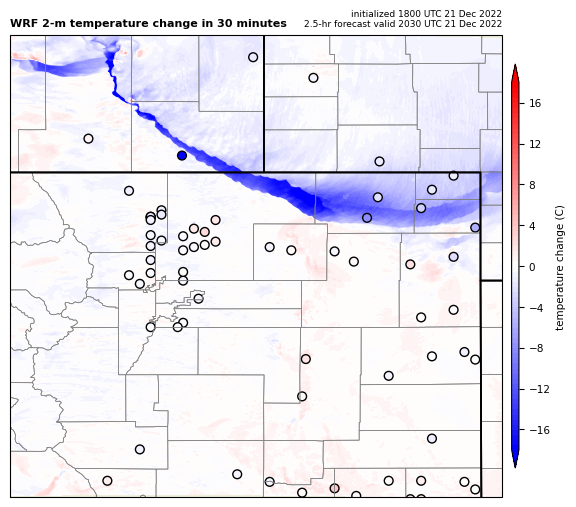

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:00:00


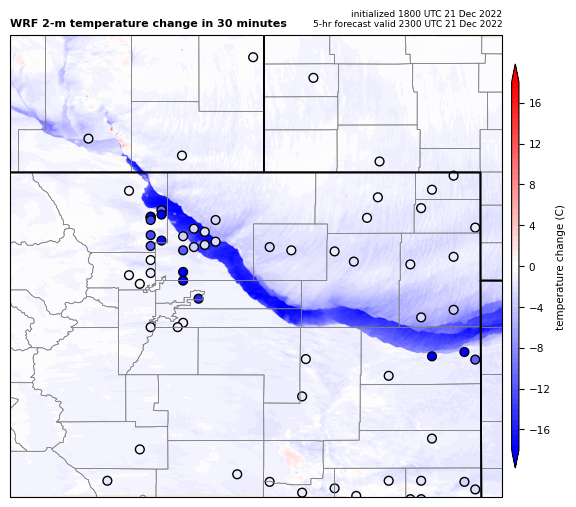

In [19]:
## now we're going to make plots for a series of hours
## define our end hours

init = pd.Timestamp(2022,12,21,18)

#endhrs=['20:00','20:30','21:00','21:30','22:00','22:30','23:00','23:30']
endhrs=['20:30','23:00']
#endhrs=['00:00','00:30','01:00','01:30','02:00','02:30','03:00']

diff_minutes = 30  ##### how many minutes to calculate the difference? 

for endhr in endhrs:
    
    ## get the times we need
    times = pd.date_range(start=pd.Timestamp('2022-12-21 '+str(endhr)) - pd.Timedelta(minutes=diff_minutes), end='2022-12-21 '+str(endhr), 
                          freq=str(diff_minutes)+"min")


    # wrf filenames matching these times
    wrf_filenames = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+times.strftime("%Y-%m-%d_%H:%M:%S") 
    
    ## identify the two files here
    wrf_filename_last = wrf_filenames[-1]
    wrf_filename_first = wrf_filenames[0]
    
    print("working on "+wrf_filename_last)
    
    ## read in some files
    ncfile_last = [nc(wrf_filename_last)]
    ncfile_first = [nc(wrf_filename_first)]
    
    ## read in T2 
    t2m_end = getvar(ncfile_last,"T2")
    t2m_start = getvar(ncfile_first,"T2")
    
    ## valid time
    vtime = pd.to_datetime(t2m_end.Time.values)
    
    ## what's the lead time (in hours)?
    fcst_lead = np.round((t2m_end.XTIME/60.).values,2)
    ## format this more nicely (removing the decimal if it's the top of the hour)
    fcst_lead_nice = int(fcst_lead.item()) if fcst_lead.item().is_integer() else np.round(fcst_lead.item(),2)
    
    ####### now let's make a map of reflectivity and the surface wind swath
    # Get the latitude and longitude points
    lats, lons = latlon_coords(t2m_end)

    # Get the cartopy mapping object
    #cart_proj = get_cartopy(dbz_1km)
    cart_proj = ccrs.PlateCarree()
    
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)
    
    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'),linewidth=1.25)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    
    #ax.set_extent([-106.49114990234375,-101.61444091796875,37.97676467895508,42.27891540527344])
    ax.set_extent([-106.4,-101.85,38.0,42.27])

    cf = ax.contourf(to_np(lons), to_np(lats), to_np(t2m_end - t2m_start), 
                    np.arange(-18,18.5,0.5),
                       cmap='bwr',
                     extend='both',
                      transform_first=True,
                 transform=ccrs.PlateCarree())
      
    cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                      shrink=0.875, aspect=50)
    cb.ax.tick_params(labelsize=7.5)
    cb.set_label('temperature change (C)', fontsize=7.5)
    #cb.locator = ticker.MaxNLocator(nbins=14)
    #cb.update_ticks()
    
    coag_this = coag_east.reset_index(drop=False).set_index("Date and Time")[times[1].strftime("%Y-%m-%d %H:%M"):times[1].strftime("%Y-%m-%d %H:%M")]
    ax.scatter(coag_this['Longitude (degE)'],coag_this['Latitude (degN)'],s=40,
              c=-coag_this["Tchange_"+str(diff_minutes)+"min"],
               cmap='bwr', vmin=-18,vmax=18.5, edgecolors='black',
               transform=ccrs.PlateCarree())

    asos_this = asos.reset_index(drop=False).set_index("datetime")[times[1].strftime("%Y-%m-%d %H:%M"):times[1].strftime("%Y-%m-%d %H:%M")]
    ax.scatter(asos_this['lon'],asos_this['lat'],s=40,
              c=-asos_this["Tchange_"+str(diff_minutes)+"min"],
               cmap='bwr', vmin=-18,vmax=18.5, edgecolors='black',
               transform=ccrs.PlateCarree())
    
    # add titles
    plt.title("WRF 2-m temperature change in "+str(diff_minutes)+" minutes",
              loc='left', weight='bold', fontsize=8)
    plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(fcst_lead_nice)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
          loc='right', fontsize=6.5)
    
    plt.show()

    fig.savefig("t2m_change_coag_"+str(diff_minutes)+"_"+init.strftime("%Y%m%d%H")+"_"+vtime.strftime("%H%M")+".pdf",
               bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

    plt.close('all')

### make 2-panel version

2022-12-21 20:30:00
working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:30:00
2022-12-21 23:00:00
working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:00:00


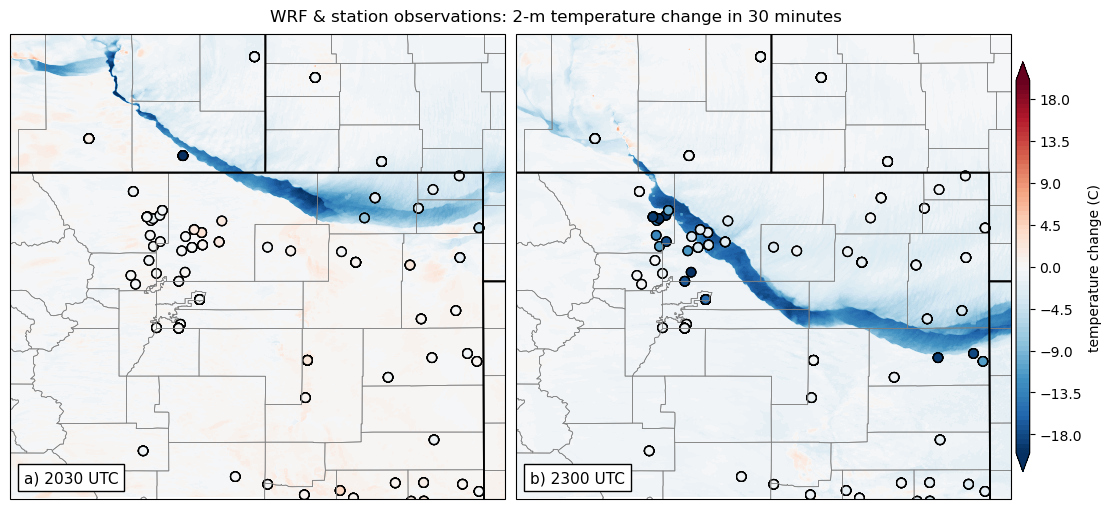

In [62]:
# Get the cartopy mapping object
#cart_proj = get_cartopy(dbz_1km)
cart_proj = ccrs.PlateCarree()

diff_minutes = 30  ##### how many minutes to calculate the difference? 

times = ['20:30','23:00']

panel_names = {'20:30':'a) 2030 UTC', '23:00':'b) 2300 UTC'}

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    times,
], layout='constrained', figsize=(11,5), subplot_kw={'projection': cart_proj})

for tt in times:

    vtime_str = '2022-12-21 '+tt
    vtime = pd.to_datetime(vtime_str)
    start_time = vtime - pd.Timedelta(minutes=diff_minutes)

    print(vtime)
    
    # wrf filename matching these times
    wrf_filename_end = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+vtime.strftime("%Y-%m-%d_%H:%M:%S") 
    wrf_filename_start = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+start_time.strftime("%Y-%m-%d_%H:%M:%S")    
       
    print("working on "+wrf_filename_end)
    
    ## read in some files
    ncfile_end = [nc(wrf_filename_end)]
    ncfile_start = [nc(wrf_filename_start)]
    
    ## read in T2 
    t2m_end = getvar(ncfile_end,"T2")
    t2m_start = getvar(ncfile_start,"T2")
    
    
    ## what's the lead time (in hours)?
    fcst_lead = np.round((t2m_end.XTIME/60.).values,2)
    ## format this more nicely (removing the decimal if it's the top of the hour)
    fcst_lead_nice = int(fcst_lead.item()) if fcst_lead.item().is_integer() else np.round(fcst_lead.item(),2)
    
    ####### now let's make a map of reflectivity and the surface wind swath
    # Get the latitude and longitude points
    lats, lons = latlon_coords(t2m_end)

    # Add some various map elements to the plot to make it recognizable.
    #axs[tt].add_feature(cfeature.LAND.with_scale('10m'))
    axs[tt].add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.5)
    axs[tt].add_feature(cfeature.STATES.with_scale('10m'),linewidth=1.25)
    axs[tt].add_feature(cfeature.BORDERS.with_scale('10m'))
    
    #ax.set_extent([-106.49114990234375,-101.61444091796875,37.97676467895508,42.27891540527344])
    axs[tt].set_extent([-106.4,-101.85,38.0,42.27])

    clevs = np.arange(-20,20.5,0.5)

    cf = axs[tt].contourf(to_np(lons), to_np(lats), to_np(t2m_end - t2m_start), 
                    clevs,
                      # cmap='bwr',
                          cmap=RdBu_11_r.mpl_colormap,
                     extend='both',
                      transform_first=True,
                 transform=ccrs.PlateCarree())

    if tt==times[-1]:
        cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                          shrink=0.875, aspect=30)
        cb.ax.tick_params(labelsize=10)
        cb.set_label('temperature change (C)', fontsize=10)
        #cb.locator = ticker.MaxNLocator(nbins=14)
        #cb.update_ticks()
    
    coag_this = coag_east.reset_index(drop=False).set_index("Date and Time")[start_time.strftime("%Y-%m-%d %H:%M"):vtime.strftime("%Y-%m-%d %H:%M")]
    axs[tt].scatter(coag_this['Longitude (degE)'],coag_this['Latitude (degN)'],s=45,
              c=-coag_this["Tchange_"+str(diff_minutes)+"min"],
               #cmap='bwr', 
                    cmap=RdBu_11_r.mpl_colormap,
                    #vmin=-18,vmax=18.5, 
                    vmin=clevs[0], vmax=clevs[-1],
                    edgecolors='black',
               transform=ccrs.PlateCarree())

    asos_this = asos.reset_index(drop=False).set_index("datetime")[start_time.strftime("%Y-%m-%d %H:%M"):vtime.strftime("%Y-%m-%d %H:%M")]
    axs[tt].scatter(asos_this['lon'],asos_this['lat'],s=45,
              c=-asos_this["Tchange_"+str(diff_minutes)+"min"],
               #cmap='bwr', 
                    cmap=RdBu_11_r.mpl_colormap,
                    #vmin=-18,vmax=18.5, 
                    vmin=clevs[0], vmax=clevs[-1],
                    edgecolors='black',
               transform=ccrs.PlateCarree())

    ### panel label
    text = AnchoredText(panel_names[tt],
                    loc='lower left', prop={'size': 11}, frameon=True, zorder=20)
    axs[tt].add_artist(text)
    
plt.suptitle("WRF & station observations: 2-m temperature change in 30 minutes", fontsize=12)

# add titles
# plt.title("WRF 2-m temperature change in "+str(diff_minutes)+" minutes",
#           loc='left', weight='bold', fontsize=8)
# plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(fcst_lead_nice)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
#       loc='right', fontsize=6.5)

plt.show()

fig.savefig("t2m_change_coag_"+str(diff_minutes)+"_2panel.pdf",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.close('all')

In [7]:
cart_proj.proj4_params

{'ellps': 'WGS84',
 'a': 6378137.0,
 'proj': 'eqc',
 'lon_0': 0.0,
 'to_meter': 111319.49079327357,
 'vto_meter': 1}

In [10]:
ax.get_extent()

(-106.49114990234375,
 -101.61444091796875,
 37.97676467895508,
 42.27891540527344)

<AxesSubplot:xlabel='Date and Time'>

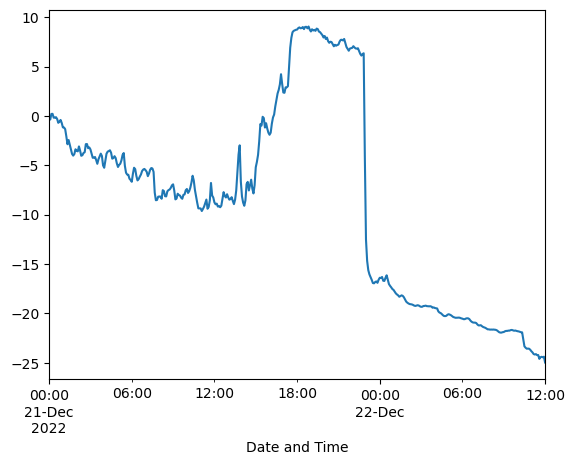

In [24]:
coag_east[coag_east.Station=="fcc01"]['Air Temp'].plot()